In [1]:
import torch
from torch import Tensor

In [8]:
def precompute_theta_pos_freq(
    head_dim: int, 
    seq_len: int, 
    device: str = 'cpu', 
    theta: float = 10_000.0
) -> Tensor:
    """
    theta_i = 10_000 ^ (-2(i-1)/dim) for i in [1, 2, ..., dim / 2]
    """
    assert head_dim % 2 == 0, 'Dimension must be divisible by 2'  # está no paper
    theta_numerator = torch.arange(0, head_dim, 2).float()
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)  # [theta_1, ..., theta_dim/2]
    theta = theta.round(decimals=2)
    m = torch.arange(seq_len, device=device)  # [1, 2, ..., seq_len]
    freqs = torch.outer(m, theta).float()  # matrix: [[m1.theta1, ..., m1.thetad/2], [m2.theta1, ..., m2.thetad/2], ..., [m3.theta1, ..., m3.thetad/2]]
    freqs = freqs.round(decimals=2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex, freqs

In [11]:
freqs_complex, freqs = precompute_theta_pos_freq(head_dim=8, seq_len=16)

In [15]:
print(f'A matrix:\n{freqs}')
print()
print(f'A matrix em cordenadas polares:\n{freqs_complex}')

A matrix:
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e-01, 1.0000e-02, 0.0000e+00],
        [2.0000e+00, 2.0000e-01, 2.0000e-02, 0.0000e+00],
        [3.0000e+00, 3.0000e-01, 3.0000e-02, 0.0000e+00],
        [4.0000e+00, 4.0000e-01, 4.0000e-02, 0.0000e+00],
        [5.0000e+00, 5.0000e-01, 5.0000e-02, 0.0000e+00],
        [6.0000e+00, 6.0000e-01, 6.0000e-02, 0.0000e+00],
        [7.0000e+00, 7.0000e-01, 7.0000e-02, 0.0000e+00],
        [8.0000e+00, 8.0000e-01, 8.0000e-02, 0.0000e+00],
        [9.0000e+00, 9.0000e-01, 9.0000e-02, 0.0000e+00],
        [1.0000e+01, 1.0000e+00, 1.0000e-01, 0.0000e+00],
        [1.1000e+01, 1.1000e+00, 1.1000e-01, 0.0000e+00],
        [1.2000e+01, 1.2000e+00, 1.2000e-01, 0.0000e+00],
        [1.3000e+01, 1.3000e+00, 1.3000e-01, 0.0000e+00],
        [1.4000e+01, 1.4000e+00, 1.4000e-01, 0.0000e+00],
        [1.5000e+01, 1.5000e+00, 1.5000e-01, 0.0000e+00]])

A matrix em cordenadas polares:
tensor([[ 1.0000+0.0000j,  1

In [17]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    # As written in the paragraph 3.2.2 of the paper
    # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
    assert head_dim % 2 == 0, "Dimension must be divisible by 2"
    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device) # (Dim / 2)
    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

In [18]:
H_dim = 8
Head_dim = 2
L = 8

In [19]:
freqs_complex, freqs = precompute_theta_pos_freq(head_dim=H_dim, seq_len=L)

In [20]:
freqs_complex

tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.9950+0.0998j,  0.9999+0.0100j,  1.0000+0.0000j],
        [-0.4161+0.9093j,  0.9801+0.1987j,  0.9998+0.0200j,  1.0000+0.0000j],
        [-0.9900+0.1411j,  0.9553+0.2955j,  0.9996+0.0300j,  1.0000+0.0000j],
        [-0.6536-0.7568j,  0.9211+0.3894j,  0.9992+0.0400j,  1.0000+0.0000j],
        [ 0.2837-0.9589j,  0.8776+0.4794j,  0.9988+0.0500j,  1.0000+0.0000j],
        [ 0.9602-0.2794j,  0.8253+0.5646j,  0.9982+0.0600j,  1.0000+0.0000j],
        [ 0.7539+0.6570j,  0.7648+0.6442j,  0.9976+0.0699j,  1.0000+0.0000j]])

In [21]:
# aqui mostra o porque quanto mais para lá --> mais demorado o "relogio" da uma volta
freqs

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.1000, 0.0100, 0.0000],
        [2.0000, 0.2000, 0.0200, 0.0000],
        [3.0000, 0.3000, 0.0300, 0.0000],
        [4.0000, 0.4000, 0.0400, 0.0000],
        [5.0000, 0.5000, 0.0500, 0.0000],
        [6.0000, 0.6000, 0.0600, 0.0000],
        [7.0000, 0.7000, 0.0700, 0.0000]])

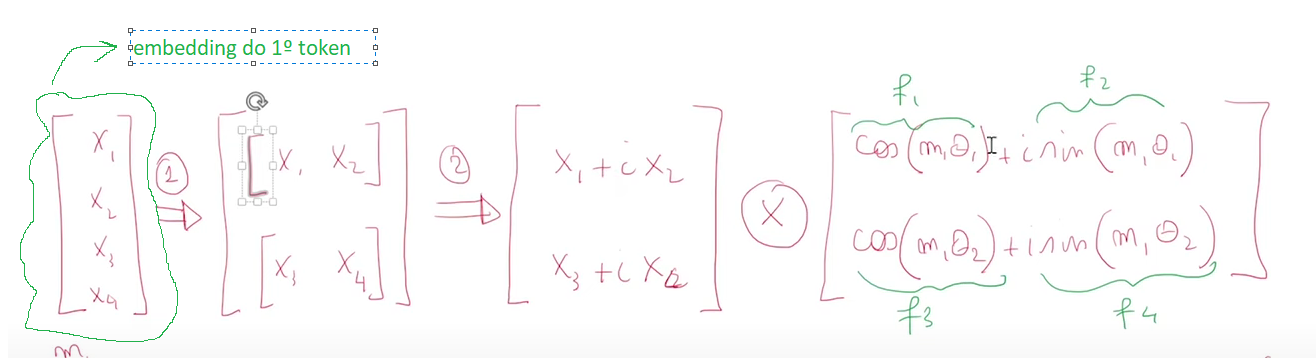

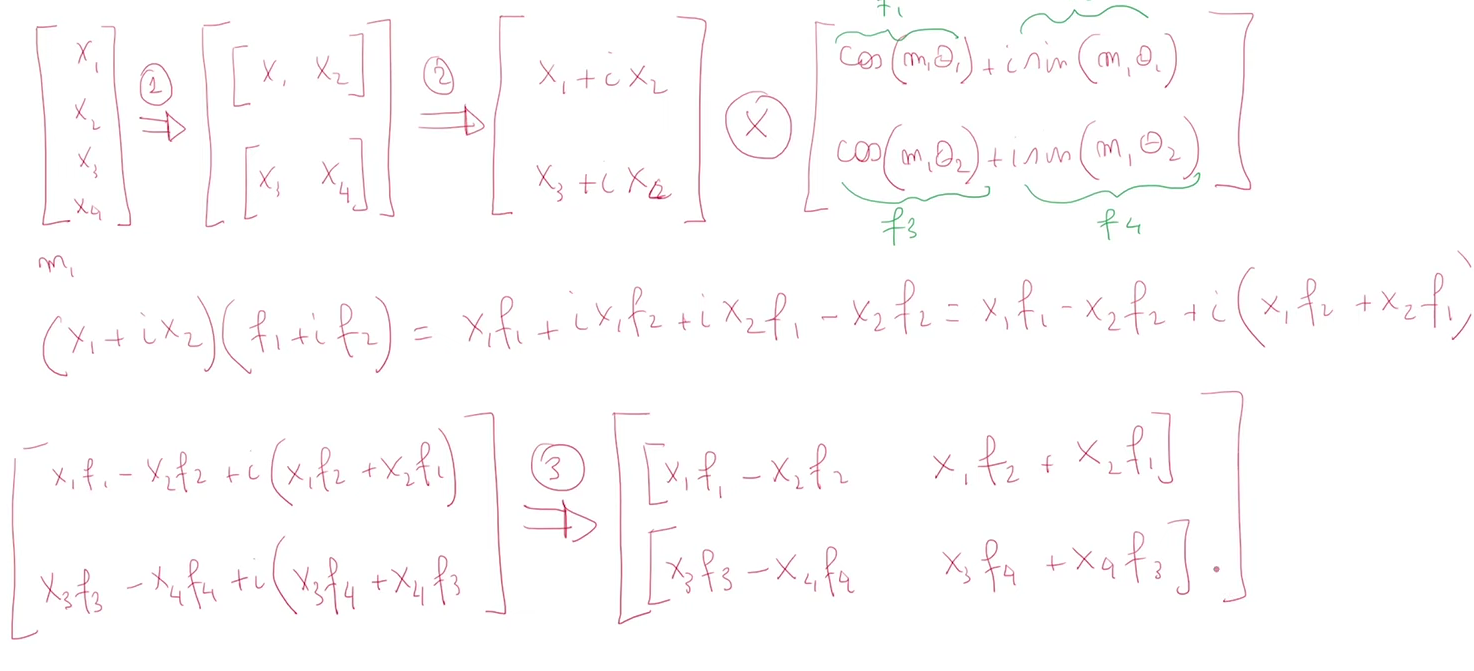

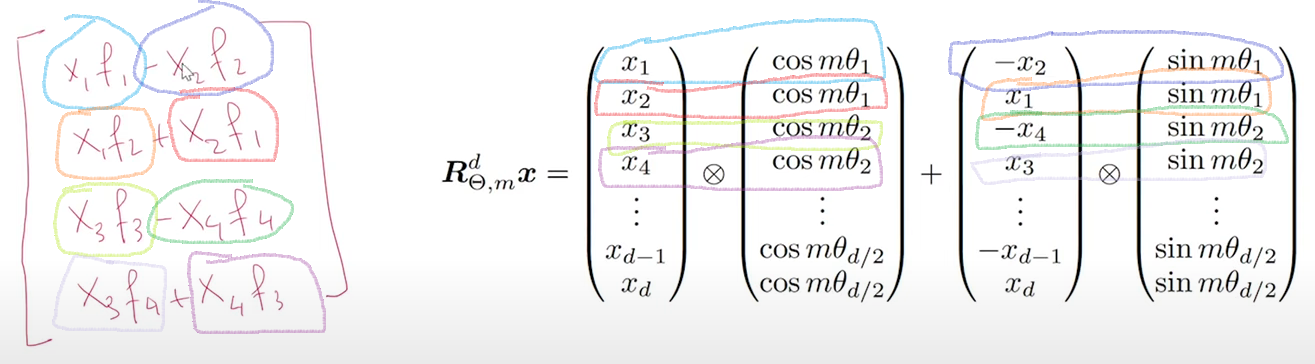

In [87]:
def apply_rotary_embeddings(
    x: Tensor, 
    freqs_complex: Tensor, 
    device: str = 'cpu'
):
    """
    Está função segue a imagem acima
    """
    # item 1 da imagem
    # (B, Seq_len, H, Head_dim) -> (B, Seq_len, H, Head_dim / 2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # (Seq_len, Head_dim / 2) -> (1, Seq_len, 1, Head_dim / 2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # item 2 da imagem
    # (B, Seq_len, H, Head_dim / 2) * (1, Seq_len, 1, Head_dim / 2) = (B, Seq_len, H, Head_dim / 2)
    x_rotated = x_complex * freqs_complex
    # item 3 da imagem
    # (B, Seq_len, H, Head_dim / 2) -> (B, Seq_len, H, Head_dim / 2)
    x_out = torch.view_as_real(x_rotated)
    # ultimo item da imagem
    # (B, Seq_len, H, Head_dim / 2) -> (B, Seq_len, H, Head_dim)
    # x_out = x_out.reshape(*x.shape)
    x_out = x_out.reshape(x_out.shape[0], x_out.shape[1], x_out.shape[2], -1)
    return x_out.type_as(x).to(device)

In [88]:
# isso porque N_HEADS * D_HEADS = D_MODEL
N = 1  # batch size
L = 2  # seq len
N_HEADS = 2 
D_HEADS = 2
D_MODEL = 4

In [97]:
freqs_complex, _ = precompute_theta_pos_freq(D_HEADS, L)

In [98]:
freqs_complex

tensor([[1.0000+0.0000j],
        [0.5403+0.8415j]])

In [90]:
# aqui o tensor já está pronto para se passar a atenção
x = torch.rand((B, SEQ_LEN, N_HEADS, D_HEADS))

In [91]:
x

tensor([[[[0.7582, 0.2895],
          [0.4904, 0.3509]],

         [[0.9973, 0.9623],
          [0.7623, 0.5373]]]])

In [92]:
# aplica o RoPE
x_rope = apply_rotary_embeddings(x, freqs_complex)
x_rope

tensor([[[[ 0.7582,  0.2895],
          [ 0.4904,  0.3509]],

         [[-0.2709,  1.3591],
          [-0.0402,  0.9318]]]])

In [95]:
# volta o tensor para (N, L, D_MODEL)
x_rope = x_rope.contiguous().view((-1, N_HEADS, L, D_HEADS)).transpose(1, 2)
print('x:', x_rope.shape)
x_rope

x: torch.Size([1, 2, 2, 2])


tensor([[[[ 0.7582,  0.2895],
          [-0.2709,  1.3591]],

         [[ 0.4904,  0.3509],
          [-0.0402,  0.9318]]]])

In [96]:
x_rope = x_rope.contiguous().view((-1, L, D_MODEL))
print('x:', x_rope.shape)
x_rope

x: torch.Size([1, 2, 4])


tensor([[[ 0.7582,  0.2895, -0.2709,  1.3591],
         [ 0.4904,  0.3509, -0.0402,  0.9318]]])